### Activamos multi-threading en VSCode con JupyterNotebook

+ [https://docs.julialang.org/en/v1/manual/multi-threading/](https://docs.julialang.org/en/v1/manual/multi-threading/)
+ [https://enccs.github.io/Julia-for-HPC/multithreading/](https://enccs.github.io/Julia-for-HPC/multithreading/)
+ [https://stackoverflow.com/questions/71596187/changing-threads-in-settings-json-of-vs-code-for-julias-jupyter-notebooks](https://stackoverflow.com/questions/71596187/changing-threads-in-settings-json-of-vs-code-for-julias-jupyter-notebooks)

Con el siguiente comando podemos consultar los número de threads disponibles para multithreads, para ello, fue necesario configurar directamente desde VSCode los parámetros de threads para Julia desde JupyterNotebook.

In [414]:
println("Number of threads = ", Threads.nthreads());

Number of threads = 4


# Desarrollo numérico para resolver la ecuación de Schrödinger dependiente del tiempo mediante el método implícito

## 1. Importamos módulo con funciones, parámetros y algorítmos útiles

In [2]:
include("../modules/module_schrodinger_equation_testing_04.jl"); # módulo para construir grilla (2D)

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


VARIABLES GLOBALES:
m=1.0000 (mass)
ω=1.0000 (frecuency)
ħ=1.0000 (Planck constant)
γ=0.1000 (coupling)


x₁=0.0000 x₂=2.0000 y₁=0.0000 y₂=2.0000 (QHO origin position)


## 2. Definimos propiedades de la grilla y resolvemos problema de autovalores

Acá la idea es crear la grilla 2D con propiedades de tamaño de elementos finitos y condiciones de borde (de tipo Dirichlet homogeneas). Además, resolvemos el problema de autovalores para el hamiltoniano del oscilador armónico $\hat {h}_{x_0=0}(x)$ y calculamos las autoenergías y autoestados útiles para contruir la condición inicial en el problema de evolución.

In [58]:
n_2D=50;dom_2D=(-25.0,25.0,-25.0,25.0);                # cantidad de FE y dominio espacial
Δxₕ=1.0/n_2D;                                           # tamaño del elemento 2D
partition_2D=(n_2D,n_2D);                               # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);   # creamos modelo con elementos cartesianos

write_data=true
if write_data
    writevtk(model_2D,path_images*"model_2D");            # escribimos el modelo para visualizar con Visit
end

BCtype="fulldirichlet";
if BCtype=="fulldirichlet"
    println("BCtype = ",BCtype);
    # modified
    labels_2D = get_face_labeling(model_2D);
    add_tag_from_tags!(labels_2D,"D1",[1,7,3,2,4,8]);   # lineas laterales + 4 puntos vértice
    add_tag_from_tags!(labels_2D,"D2",[5,6]);           # lineas superior e inferior
    dirichlet_values_2D=[0.0+im*0.0,0.0+im*0.0];
    dirichlet_tags_2D=["D1","D2"];
end

Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
order_2D=2;reffe_2D=ReferenceFE(lagrangian,Float64,order_2D);

Vₕ_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
Uₕ_2D=TrialFESpace(Vₕ_2D,dirichlet_values_2D);

nevₕ=5;
aₕ_2D,bₕ_2D=bilineal_forms(pₕ,qₕ_2D,rₕ,dΩ_2D);
probₕ_2D=EigenProblem(aₕ_2D,bₕ_2D,Uₕ_2D,Vₕ_2D;nev=nevₕ,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0)
ϵₕ_2D,ϕₕ_2D=solve(probₕ_2D);

BCtype = fulldirichlet


In [59]:
# Escribimos autovectores para visualizar externamente
write_data=true;
if write_data
    for i in 1:nevₕ
        ϕₕi_2D = ϕₕ_2D[i]; # autovector asociado al autovalor 6
        writevtk(Ω_2D,path_images*"eigenprob_2D_01_num$(i)",cellfields=["phi_real" => real(ϕₕi_2D), "phi_imag" => imag(ϕₕi_2D)]);
    end
end

> useful links to embeded mp4 inside Markdown Julia
 + [https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video)
 + [https://www.freeconvert.com/mpeg-to-mp4](https://www.freeconvert.com/mpeg-to-mp4)


### Mostramos salida de Densidad de probabilidad con visualizador Visit para los autoestados

<video controls width="500">
  <source src="./videos/eigenprob_2D.mp4" type="video/mp4" />
</video>

Notemos que al usar una resolución espacial pobre, los autoestados más exitados se alejan mucho de los exáctos, sin embargo, como sólo estamos interesados en el autoestado fundamental para construir la condición inicial, creemos que los resultados son razonables.

## 3. Resolvemos la ecuación de evolución (ecuación de Schrödinger dependiente del tiempo) con método de Euler implícito

### 3.1. Definimos variables temporales

In [68]:
scale_factor_fs = 0.02418884
t₀=0.0;t₁=10;                    # final time for test
num_steps=50001;                     # number of time steps   
n_int=2500;                           # Intervals where data is saved n_int=(num_steps-1)/20
Δt=abs(t₁-t₀)*(1.0/(num_steps-1))   # time step

0.0002

Aquí mostramos factores de interes, como ser:
+ El factor $\frac {\Delta t}{\Delta x^2}$ nos permite corroborar que, si es pequeño $( \lt 1)$, el método de Euler usual funcionaría.
+ El factor $\frac {\Delta t}{\Delta x}$ si es aproximadamente igual a 1, y no usamos métodos implícitos, el método explícito sería intestable.
+ El factor $\left ( \frac {\Delta t}{\Delta x^2} \right)^3$ nos dice cómo escala el error del método implícito.

In [69]:
@printf("Δt/Δx²=%.6f\nΔt/Δx=%.6f\nΔt³/Δx⁶=%.6f",Δt/(Δxₕ^2),(Δt/Δxₕ),(Δt/(Δxₕ^2))^3)

Δt/Δx²=0.500000
Δt/Δx=0.010000
Δt³/Δx⁶=0.125000

### 3.2. Construimos espacios Trial y Test
Como resolvemos la evolución en componentes de la función de onda, tendremos que construir espacios Test y Trial de tipo `MultiFieldFESpace()`.

In [70]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
U₁H_2D=TrialFESpace(V₁H_2D,dirichlet_values_2D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
U₂H_2D=TrialFESpace(V₂H_2D,dirichlet_values_2D);
# creamos un campo de espacios
UH_2D = MultiFieldFESpace([U₁H_2D, U₂H_2D]);
VH_2D = MultiFieldFESpace([V₁H_2D, V₂H_2D]);

### 3.3. Construimos la condición inicial

Para construir la condición inicial utilizamos la función de interpolación para crear objetos en un dominio específico, es decir, en el dominio del hamiltoniano $\hat {h}_{x_0=0}(x)$, e interpolamos en otro domino específico, es decir, en el dominio del hamiltoniano del sistema $\hat {H}(x)$. De esta forma creamos una condición inicial donde una de las componentes sea la autofunción del hamiltoniano individual $\hat {h}_{x_0=0}(x)$.

In [71]:
u₀ₕ_2D=interpolate_everywhere(ϕₕ_2D[1],Uₕ_2D);
interp_u₀ₕ_2D=Interpolable(u₀ₕ_2D);

In [72]:
type_BC=1;
if (type_BC==1)
    u₁0H_2D_v₁(x)=0.0;
    u₂0H_2D_v₁=interpolate_everywhere(interp_u₀ₕ_2D,U₂H_2D);
    u₀H_2D=interpolate_everywhere([u₁0H_2D_v₁,u₂0H_2D_v₁],UH_2D);
elseif (type_BC==2)
    u₁0H_2D_v₂=interpolate_everywhere(interp_u₀ₕ_2D,U₁H_2D);
    u₂0H_2D_v₂(x)=0.0;
    u₀H_2D=interpolate_everywhere([u₁0H_2D_v₂,u₂0H_2D_v₂],UH_2D);
end

MultiFieldFEFunction():
 num_cells: 2500
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 69910650535278999

Si es requerido podemos escribir datos en formato vtk para visualizar externamente.

In [73]:
write_data=true
if write_data
    writevtk(Ω_2D,path_images*"evol_ini_dat_2D_$(lpad(0,3,'0'))", cellfields=["u10H_2D_re"=>real(u₀H_2D[1]),"u10H_2D_im"=>imag(u₀H_2D[1]),
    "u20H_2D_re"=>real(u₀H_2D[2]),"u20H_2D_im"=>imag(u₀H_2D[2])])
end

(["../outputs/Output_Testing_04_SingleEigenProblemAndImplicitMethod/images/evol_ini_dat_2D_000.vtu"],)

Mostramos norma $L_2$ de las coordenadas de la condición inicial para asegurarnos sus propiedades.

In [74]:
@printf("norm L₂u₁=%.6f,norm L₂u₂=%.6f",norm_L2(u₀H_2D[1],dΩ_2D),norm_L2(u₀H_2D[2],dΩ_2D))

norm L₂u₁=0.000000,norm L₂u₂=1.000000

### 3.4. Definimos forma bilineal $a((u_1,u_2),(v_1,v_2))$ y matriz principal A

In [75]:
a_H_2D=a_bilineal_forms_2D(α₁,α₂,Δt,dΩ_2D);

assem_H=SparseMatrixAssembler(UH_2D,VH_2D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_2D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_2D);                   # escribimos u en la base de FE de U
mat_contribs_H=a_H_2D(du_H,dv_H);                       # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_2D,VH_2D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);                    # creamos matriz A con contribuciones y datos

Mostramos cuáles son los elementos no nulos de la matriz sparce A, qué buscaremos diagonalizar en cada paso temporal

In [76]:
display(A_H)

19602×19602 SparseMatrixCSC{ComplexF64, Int64} with 611524 stored entries:
⠻⣦⡀⠀⠀⠛⠶⣤⣀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠳⣄⠀⠀⠈⠛⠶⣤⣀⠀⠀⠀⠀⠀⠘⢷⣄⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠉⠛⠶⣤⣀⠀⠀⠀⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠉⠛⠶⣤⣀⠀⠀⠀⠉⠳⣄⠀
⣤⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠉⠛⠶⣄⠀⠀⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠉⠛⢶⡄⠀⠀⠈⠳
⠘⣧⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠹⣆⠀⠀⠀⠹⣆⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⢻⡄⠀⠀⠀
⠀⠘⣧⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠹⣆⠀⠀⠀⠹⣆⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⢻⡄⠀⠀
⠀⠀⠘⣧⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠹⣆⠀⠀⠀⠹⣆⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⢻⡄⠀
⠀⠀⠀⠘⣧⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠹⣆⠀⠀⠀⠹⣆⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⢻⡄
⢦⡀⠀⠀⠘⢧⣄⡀⠀⠀⠀⠀⠀⠈⠛⢄⠀⠀⠀⠙⣦⡀⠀⠀⠹⢤⣀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠛
⠀⠙⢦⡀⠀⠀⠈⠙⠳⢦⣄⡀⠀⠀⠀⠀⠑⢄⠀⠀⠈⠻⣄⠀⠀⠀⠈⠙⠲⢤⣀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠈⠙⠳⢦⣄⠀⠀⠀⠑⢄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠈⠙⠲⢤⣀⠀⠀⠈⠳⣄
⠙⢦⡀⠀⠀⠙⠳⢦⣄⡀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠻⣦⡀⠀⠈⠙⠳⢦⣄⡀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀
⠀⠀⠙⢦⡀⠀⠀⠀⠈⠙⠳⢦⣄⡀⠀⠀⠀⠙⢦⡀⠀⠈⠻⣦⡀⠀⠀⠀⠈⠙⠳⢦⣄⡀⠀⠀⠈⠳⣄⠀
⣦⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠈⠙⠓⣆⠀⠀⠀⠙⣆⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠈⠙⠳⡄⠀⠀⠈⠓
⠘⣧⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠘⣆⠀⠀⠀⠹⣆⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠹⡄⠀⠀⠀
⠀⠘⣧⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠘⣆⠀⠀⠀⠹⣆⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠹⡄⠀⠀
⠀⠀⠘⣧⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠘⣆⠀⠀⠀⠹⣆⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠹⡄⠀
⠀⠀⠀⠘⣧⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠘⣆⠀⠀⠀⠹⣆⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠹⡄
⢶⣄⠀⠀⠘⠷⣤⣀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠘⢦⡀⠀⠀⠙⠦⣄⡀⠀⠀⠀⠀⠀⠈⠛⢄⠀⠀⠀⠙
⠀⠙⢧⡀⠀⠀⠀⠉⠛⠶⣤⣀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡀⠀⠀⠀⠉⠓⠦⣄⡀⠀⠀⠀⠀⠑⢄⠀⠀
⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠉⠛⠶⣤⠀⠀⠀⠙⢦⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠉⠓⠦⣄⠀⠀⠀⠑⢄

In [89]:
x,y,pts_x,pts_y=space_coord_2D(dom_2D,Δxₕ,Δxₕ);

Realizamos la evolución, definiendo en cada paso el funcional b(v) y haciendo uso del operador backslash `\` para diagonalizar

In [78]:
time_vec=[t₀+Δt*(i-1) for i in 1:n_int:(num_steps-1)];    # vector de tiempos

In [79]:
𝛹ₓₜ=Vector{CellField}(undef,length(time_vec));  # función de onda

In [80]:
# inicializamos en cero el vector de onda
uₓₜ=interpolate_everywhere(u₀H_2D,UH_2D);
u¹ₓₜ,u²ₓₜ=uₓₜ;
for i in 1:length(time_vec)
    𝛹ₓₜ[i]=interpolate_everywhere([0.0*u¹ₓₜ,0.0*u²ₓₜ],UH_2D)
end

In [81]:
index=1;
# paso inicial (t=0)
t=time_vec[index];

# guardamos función de onda
uₓₜ=interpolate_everywhere(u₀H_2D,UH_2D);
u¹ₓₜ,u²ₓₜ=uₓₜ;
𝛹ₓₜ[index]=interpolate_everywhere([u¹ₓₜ,u²ₓₜ],UH_2D)

norm_switch=true
if norm_switch
    Norm𝛹ₓₜ=normalization_eigenstates_2D(𝛹ₓₜ,UH_2D,dΩ_2D)
    𝛹ₓₜ¹=interpolate_everywhere(𝛹ₓₜ[index],UH_2D)
    𝛹¹ₓₜ¹,𝛹²ₓₜ¹=𝛹ₓₜ¹
    𝛹ₓₜ[index]=interpolate_everywhere([𝛹¹ₓₜ¹/Norm𝛹ₓₜ[index],𝛹²ₓₜ¹/Norm𝛹ₓₜ[index]],UH_2D)

    # actualizamos condición inicial normalizada
    u₀H_2D=𝛹ₓₜ[index];
end

# escribimos datos vtk para visualizar externamente
write_data=true;
if write_data
  writevtk(Ω_2D,path_images*"evol_2D_02_$(lpad(index,3,'0'))",
  cellfields=["u1H_2D_re" => real(𝛹ₓₜ[index][1]), "u1H_2D_im" => imag(𝛹ₓₜ[index][1]),"u2H_2D_re" => real(𝛹ₓₜ[index][2]), "u2H_2D_im" => imag(𝛹ₓₜ[index][2])])
  @printf("t=%.6f,norm L₂u₁=%.6f,norm L₂u₂=%.6f\n",t,norm_L2(𝛹ₓₜ[index][1],dΩ_2D),norm_L2(𝛹ₓₜ[index][2],dΩ_2D))
end

t=0.000000,norm L₂u₁=0.000000,norm L₂u₂=1.000000


In [82]:
# evolucionamos para t>0
for i in 1:(num_steps-2)
  # construimos forma bilineal b(v₁,v₂)
  b_H_2D=b_bilineal_form_2D(α₁,α₂,u₀H_2D[1],u₀H_2D[2],Δt,dΩ_2D)

  # descomentar si queremos resolver de forma usual
  # vec_contribs_H=b_H_2D(dv_H[1],dv_H[2])
  vec_contribs_H=b_H_2D(dv_H)
  data_H=collect_cell_vector(VH_2D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)
  x_H = A_H \ b_H
  uH_2D = FEFunction(UH_2D,x_H)

  # descomentar si queremos resolver con solver (NO FUNCIONA)
  # op = Affineassem_HFEOperator(a_H_2D,b_H_2D,UH_2D,VH_2D)
  # ls=LUSolver();solver=LinearFESolver(ls)
  # uH_2D = solve(solver,op)

  # actualizamos condición inicial
  if norm_switch
    # normalizamos la función de onda luego de cada evolución
    Norm_uH_2D=normalization_eigenstates_2D_FEFunction(uH_2D,UH_2D,dΩ_2D)
    uH¹²_2D=interpolate_everywhere(uH_2D,UH_2D)
    uH¹_2D,uH²_2D=uH¹²_2D
    u₀H_2D=interpolate_everywhere([uH¹_2D/Norm_uH_2D,uH²_2D/Norm_uH_2D],UH_2D)
  else
    u₀H_2D=uH_2D
  end

  if (i % n_int == 0)
    index+=1;
    t = time_vec[index];
    
    # guardamos función de onda
    uₓₜ=interpolate_everywhere(u₀H_2D,UH_2D);
    u¹ₓₜ,u²ₓₜ=uₓₜ;
    𝛹ₓₜ[index]=interpolate_everywhere([u¹ₓₜ,u²ₓₜ],UH_2D)

    # escribimos datos vtk para visualizar externamente
    if write_data
      writevtk(Ω_2D,path_images*"evol_2D_02_$(lpad(index,3,'0'))",
      cellfields=["u1H_2D_re" => real(𝛹ₓₜ[index][1]), "u1H_2D_im" => imag(𝛹ₓₜ[index][1]),"u2H_2D_re" => real(𝛹ₓₜ[index][2]), "u2H_2D_im" => imag(𝛹ₓₜ[index][2])])
      @printf("t=%.6f,norm L₂u=%.6f\n",t,(norm_L2(𝛹ₓₜ[index][1],dΩ_2D)+norm_L2(𝛹ₓₜ[index][2],dΩ_2D)))
    end
  end
end

t=0.500000,norm L₂u=1.000000
t=1.000000,norm L₂u=1.000000


t=1.500000,norm L₂u=1.000000
t=2.000000,norm L₂u=1.000000


t=2.500000,norm L₂u=1.000000
t=3.000000,norm L₂u=1.000000


t=3.500000,norm L₂u=1.000000
t=4.000000,norm L₂u=1.000000


t=4.500000,norm L₂u=1.000000
t=5.000000,norm L₂u=1.000000


t=5.500000,norm L₂u=1.000000
t=6.000000,norm L₂u=1.000000


t=6.500000,norm L₂u=1.000000
t=7.000000,norm L₂u=1.000000


t=7.500000,norm L₂u=1.000000
t=8.000000,norm L₂u=1.000000


t=8.500000,norm L₂u=1.000000
t=9.000000,norm L₂u=1.000000


t=9.500000,norm L₂u=1.000000


Chequeamos normalización de la función de onda

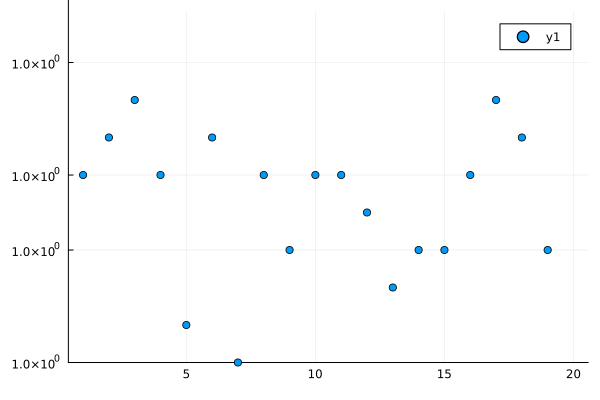

GKS: Possible loss of precision in routine SET_WINDOW


In [83]:
𝛹ₓₜ_norm=normalization_eigenstates_2D(𝛹ₓₜ,UH_2D,dΩ_2D);
scatter(𝛹ₓₜ_norm)

Para plotear los resultados en 2D dimensiones debemos calcular los puntos del dominio `pts` ligeramente diferentes al caso 1D

( para mayor detalle ver `module_schrodinger_equation_testing_04.jl`)

Para mostrar un gráfico de contorno con un relleno tipo mapa de colores consultamos las páginas
+ [https://docs.juliahub.com/CalculusWithJulia/AZHbv/0.0.7/differentiable_vector_calculus/plots_plotting.html](https://docs.juliahub.com/CalculusWithJulia/AZHbv/0.0.7/differentiable_vector_calculus/plots_plotting.html)
+ [https://docs.juliaplots.org/latest/series_types/contour/](https://docs.juliaplots.org/latest/series_types/contour/)

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/outputs/Output_Testing_04_SingleEigenProblemAndImplicitMethod/plots/density_2D_mapcolor_fps3.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/final_project/outputs/Output_Testing_04_SingleEigenProblemAndImplicitMethod/plots/density_2D_mapcolor_fps3.gif")
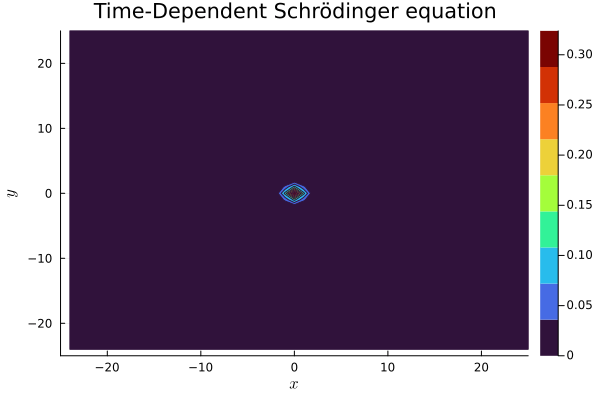

In [143]:
anim₁ = @animate for i in 1:length(time_vec)
    ρ₁Hreim_2D=real(conj(𝛹ₓₜ[i][1].(pts)).*𝛹ₓₜ[i][1].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    ρ₂Hreim_2D=real(conj(𝛹ₓₜ[i][2].(pts)).*𝛹ₓₜ[i][2].(pts)) #./ (𝛹ₓₜ_norm[i]^2)

    contourf(x[:],y[:],ρ₁Hreim_2D+ρ₂Hreim_2D,levels=8, color=:turbo)
    plot!(title="Time-Dependent Schrödinger equation",xlabel="\$x\$",ylabel="\$y\$")
    plot!(label="t = $(round(time_vec[i]; digits=4))",zlim=(0,1),xlim=(-25,25),ylim=(-25,25))
end

gif(anim₁,path_plots*"density_2D_mapcolor_fps3.gif", fps = 3)

### Mostramos salida de Densidad de probabilidad con visualizador Visit

<video controls width="500">
  <source src="./videos/evol_2D.mp4" type="video/mp4" />
</video>

<video controls width="500">
<source src="./videos/evol_2D_elevate.mp4" type="video/mp4" />
</video>

Notemos que, a pesar de la poca resolución espacial que tomamos, con el visualizador Visit logra interpolar la función correctamente, dandonos una forma funcional más suave

In [84]:
p₁H_2D,p₂H_2D=Populations_2D(𝛹ₓₜ,UH_2D,dΩ_2D); # calculamos poblaciones

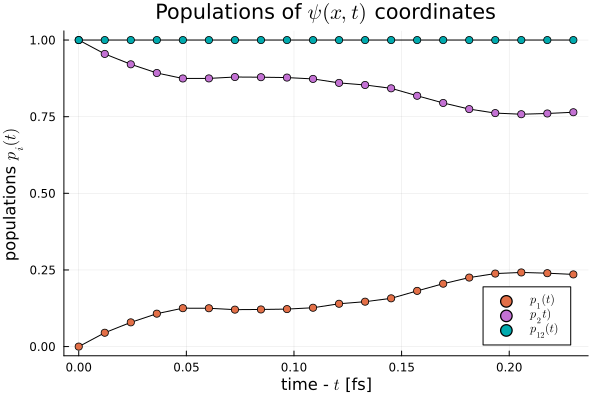

In [85]:
plotting=true
if plotting
    using Interpolations
    plot1=plot(time_vec .* scale_factor_fs,p₁H_2D,label="",lw=1,lc="black")
    plot1=scatter!(time_vec .* scale_factor_fs,p₁H_2D,label="\$p_{1}(t)\$")
    plot1=plot!(time_vec .* scale_factor_fs,p₂H_2D,label="",lw=1,lc=:"black")
    plot1=scatter!(time_vec .* scale_factor_fs,p₂H_2D,label="\$p_{2}t)\$")
    plot1=plot!(time_vec .* scale_factor_fs,(p₁H_2D .+ p₂H_2D),label="",lw=1,lc=:"black")
    plot1=scatter!(time_vec .* scale_factor_fs,(p₁H_2D .+ p₂H_2D),label="\$p_{12}(t)\$")
    plot1=plot!(title="Populations of \$\\psi(x,t)\$ coordinates",xlabel="time - \$t\$ [fs]",ylabel="populations \$p_{i}(t)\$")
    plot1=plot!(legend=:bottomright)

    display(plot1);
    savefig(plot1,path_plots*"population_wfcoord.pdf");
end

Esta simulación tardó 302 minutos (~5 horas) y somos concientes de que hemos utilizado poca resolución espacial (~ 2500 elementos) y hemos evolucionado tan solo hasta un tiempo adimensonal de 10, aunque todo esto nos requirió evolucionar ~50000 pasos temporales, para obtener un escalamiento de error aceptable (Δt/Δx=0.010000, Δt³/Δx⁶=0.125000).

Al evolucionar hasta un tiempo adimensional de 10, vemos que la evolución de la población de las coordenadas de la función de onda no es similar al caso 1D, sin embargo esto es debido a que no hemos evolucionado suficiente tiempo como para que la coordenada que partió con máxima población se "vacíe" dando lugar a un comportamiento tipo "bombeo óptico", sin embargo, los resultados son los esperables (comparar con caso unidimensional).